# Similarity Modeling 1/2: Recognizing Pigs with Deep Learning

## Student
Gallus Huber (51905700)

## Timesheet
2022-10-16 09:00 - 12:30 SIM 1 & 2
2022-10-16 15:00 - 17:00 SIM 3
2022-10-18 10:00 - 13:00 SIM 4 & 5
2022-10-27 20:00 - 22:00 SIM 6
2022-10-28 10:00 - 14:00 SIM 7 & 8 & 9
2022-11-02 08:00 - 14:00 Writing abstracts
2022-11-10 14:00 - 15:00 Meeting
2022-11-24 16:00 - 17:30 Setup
2022-11-26 09:00 - 12:00 Implementation data preparation
2022-11-27 10:00 - 10:30 Meeting
2022-11-27 10:30 - 15:00 Implementation model

## Required libraries and installs

In [87]:
!cat requirements-dl-video.txt
#!pip install -r requirements-dl-video.txt

pandas
numpy
opencv-python
matplotlib
scikit-learn
tensorflow
keras
visualkeras

## Imports

In [88]:
import os
import glob
import pathlib

import numpy as np
import pandas as pd

import cv2 as cv2
import matplotlib.pyplot as plt

import sklearn.model_selection as ms

import keras.applications as appl
import keras.models as models
import keras.layers as layers
import keras.utils as utils

## Constants

In [89]:
DATA_PATH = "../data"
GROUND_TRUTH_PATH = os.path.join(DATA_PATH, "sim12-ground-truth-muppets")
VIDEO_PATH = os.path.join(DATA_PATH, "video")

# 1. Data Preparation

## 1.1 List all videos

In [90]:
videos = glob.glob(VIDEO_PATH + '/*.avi')

videos_tmp = []
for video in videos:
    videos_tmp.append(pathlib.Path(video).name)
videos = videos_tmp

videos

['Muppets-02-01-01.avi', 'Muppets-03-04-03.avi', 'Muppets-02-04-04.avi']

## 1.1 Load ground truth

In [91]:
ground_truth = dict()

# read in corresponding ground truth
for video in videos:
        file_name = glob.glob(GROUND_TRUTH_PATH + '/*' + os.path.splitext(video)[0] + '*.csv')
        csv = pd.read_csv(os.path.join(file_name[0]), sep=";")
        ground_truth[video] = csv

### 1.2 Plot ground truth data

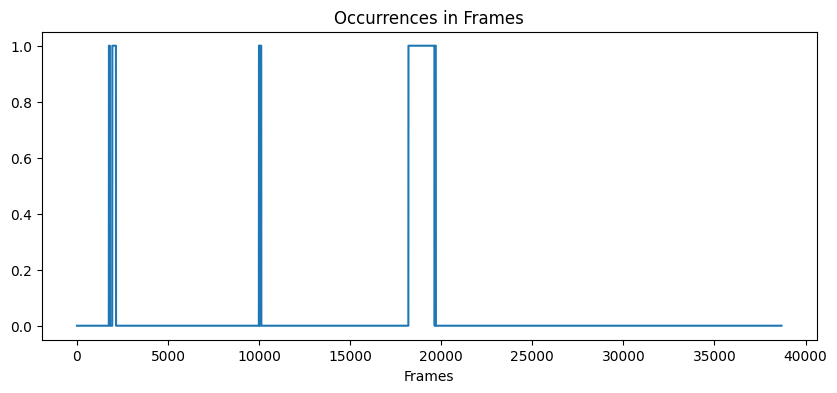

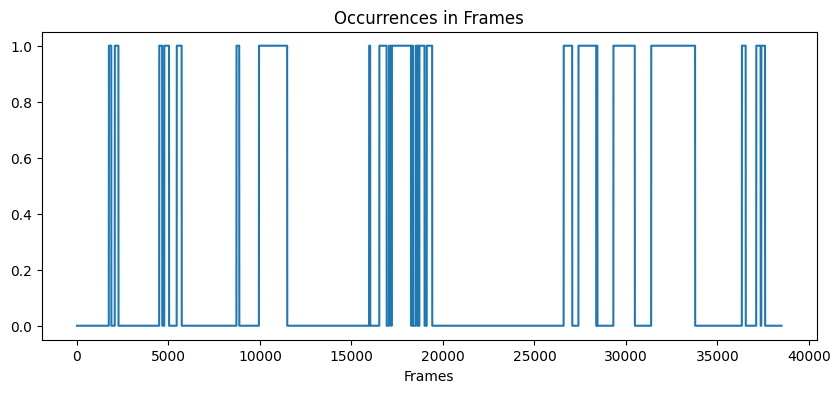

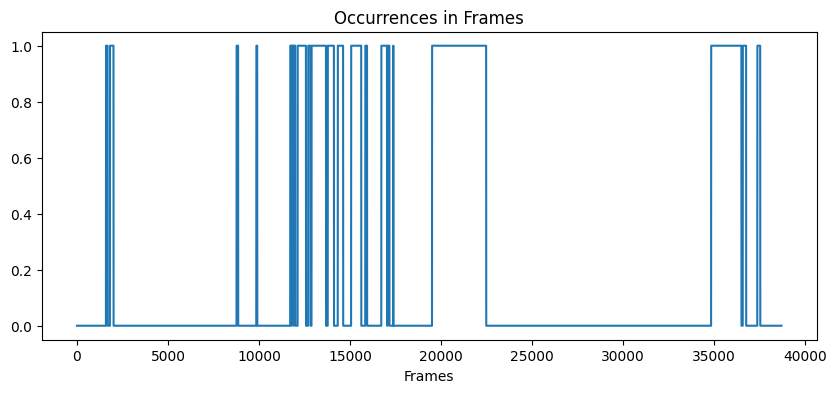

In [92]:
def plot_gt(gt, column):
    plot = plt.figure(figsize=(10, 4))

    # define subplot
    subplot = plot.add_subplot(111)
    subplot.set_title(f"Occurrences in Frames")

    # define x axis
    subplot.set_xlabel('Frames')

    # mark occurrences
    frame_indicator = np.zeros(len(gt['Frame_number']))
    frame_indicator[gt[gt[column] == 1].index] = 1

    subplot.plot(gt[column].index, frame_indicator)
    plt.show()

for video in videos:
    plot_gt(ground_truth[video], "Pigs")

## 1.3 Load video data

In [93]:
# create dirs for training
train_path = os.path.join(VIDEO_PATH, 'training_data')
train_path_0 = os.path.join(train_path, '0')
train_path_1 = os.path.join(train_path, '1')

if not os.path.exists(train_path):
    os.makedirs(train_path)
if not os.path.exists(train_path_0):
    os.makedirs(train_path_0)
if not os.path.exists(train_path_1):
    os.makedirs(train_path_1)

# create dirs for validation
valid_path = os.path.join(VIDEO_PATH, 'validation_data')
valid_path_0 = os.path.join(valid_path, '0')
valid_path_1 = os.path.join(valid_path, '1')

if not os.path.exists(valid_path):
    os.makedirs(valid_path)
if not os.path.exists(valid_path_0):
    os.makedirs(valid_path_0)
if not os.path.exists(valid_path_1):
    os.makedirs(valid_path_1)

# create dirs for testing
test_path = os.path.join(VIDEO_PATH, 'testing_data')
test_path_0 = os.path.join(test_path, '0')
test_path_1 = os.path.join(test_path, '1')

if not os.path.exists(test_path):
    os.makedirs(test_path)
if not os.path.exists(test_path_0):
    os.makedirs(test_path_0)
if not os.path.exists(test_path_1):
    os.makedirs(test_path_1)

In [94]:
train_data = dict()
valid_data = dict()
test_data = dict()

for video in videos:
    train_data[video], test_data[video] = ms.train_test_split(ground_truth[video], test_size=0.2, shuffle=True, random_state=42)
    train_data[video], valid_data[video] = ms.train_test_split(train_data[video], test_size=0.25, random_state=42)

In [95]:
def retrieve_frames(video):
    video_capture = cv2.VideoCapture(os.path.join(VIDEO_PATH, video))

    # read all frames of video
    frame_nr = 0
    while True:
        success, frame = video_capture.read()

        if not success:
            break

        # create filename
        filename = 'frame_%d.jpg' % frame_nr

        # write frames to dir
        if frame_nr in train_data[video].Frame_number:
            if (train_data[video][train_data[video].Frame_number == frame_nr].Pigs == 0).bool():
                cv2.imwrite(os.path.join(train_path_0, filename), frame)
            else:
                cv2.imwrite(os.path.join(train_path_1, filename), frame)

        elif frame_nr in valid_data[video].Frame_number:
            if (valid_data[video][valid_data[video].Frame_number == frame_nr].Pigs == 0).bool():
                cv2.imwrite(os.path.join(valid_path_0, filename), frame)
            else:
                cv2.imwrite(os.path.join(valid_path_1, filename), frame)

        elif frame_nr in test_data[video].Frame_number:
            if (test_data[video][test_data[video].Frame_number == frame_nr].Pigs == 0).bool():
                cv2.imwrite(os.path.join(test_path_0, filename), frame)
            else:
                cv2.imwrite(os.path.join(test_path_1, filename), frame)

        frame_nr += 1


for video in videos:
    retrieve_frames(video)
    print(f"Loaded frames of {video} successfully")

Loaded frames of Muppets-02-01-01.avi successfully
Loaded frames of Muppets-03-04-03.avi successfully
Loaded frames of Muppets-02-04-04.avi successfully


# 2 Model

In [96]:
for video in videos:
    print(len(test_data[video]))

7737
7700
7742


## 2.1 Build model

In [97]:
# create base model
base_model = appl.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# base model as input
head_model = base_model.output

# additional hidden layer
head_model = layers.Dense(units=512, activation='sigmoid')(head_model)

# create output layer
head_model = layers.Flatten(name="flatten")(head_model)
head_model = layers.Dense(1, activation="softmax")(head_model)

model = models.Model(inputs=base_model.input, outputs=head_model)

# base model should not be trained
for layer in base_model.layers:
	layer.trainable = False

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

## 2.2 Compile model

In [98]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## 2.3 Train model

In [99]:
for video in videos:
    train_ds = utils.image_dataset_from_directory(
        directory=train_data,
        labels='inferred',
        label_mode='binary',
        batch_size=32,
        image_size=(224, 224))

    validation_ds = utils.image_dataset_from_directory(
        directory=valid_data,
        labels='inferred',
        label_mode='binary',
        batch_size=32,
        image_size=(224, 224))

    # train model
    history = model.fit(train_ds, epochs=25, validation_data=validation_ds)

TypeError: Expected binary or unicode string, got {'Muppets-02-01-01.avi':        Video  Frame_number  Kermit  Pigs  Audio_Pigs  Cook  Audio_Cook  \
665      211           665       0     0           0     0           0   
16876    211         16876       0     0           0     0           0   
31263    211         31263       0     0           0     0           0   
23120    211         23120       0     0           0     0           0   
32435    211         32435       0     0           0     0           0   
...      ...           ...     ...   ...         ...   ...         ...   
20587    211         20587       0     0           0     0           0   
38419    211         38419       0     0           0     0           0   
1458     211          1458       0     0           0     0           0   
16575    211         16575       0     0           0     0           0   
20625    211         20625       0     0           0     0           0   

       StatlerWaldorf  Audio_StatlerWaldorf  Audio_MissPiggy  
665                 0                     0                0  
16876               1                     1                0  
31263               0                     0                0  
23120               0                     0                0  
32435               0                     0                0  
...               ...                   ...              ...  
20587               0                     0                0  
38419               1                     1                0  
1458                0                     0                0  
16575               1                     1                0  
20625               0                     0                0  

[23208 rows x 10 columns], 'Muppets-03-04-03.avi':        Video  Frame_number  Kermit  Pigs  Audio_Pigs  Cook  Audio_Cook  \
25468    343         25468       0     0           0     0           0   
28795    343         28795       0     0           0     0           0   
28468    343         28468       1     0           0     0           0   
20108    343         20108       0     0           0     0           0   
34420    343         34420       1     0           0     0           0   
...      ...           ...     ...   ...         ...   ...         ...   
28865    343         28865       0     0           0     0           0   
3595     343          3595       0     0           0     0           0   
14969    343         14969       0     0           0     0           0   
22170    343         22170       0     0           0     1           1   
20390    343         20390       0     0           0     0           0   

       StatlerWaldorf  Audio_StatlerWaldorf  Audio_MissPiggy  
25468               0                     0                0  
28795               0                     0                0  
28468               0                     0                0  
20108               0                     0                0  
34420               0                     0                0  
...               ...                   ...              ...  
28865               0                     0                0  
3595                0                     0                0  
14969               0                     0                0  
22170               0                     0                0  
20390               0                     0                0  

[23098 rows x 10 columns], 'Muppets-02-04-04.avi':        Video  Frame_number  Kermit  Pigs  Audio_Pigs  Cook  Audio_Cook  \
11730    244         11730       0     1           0     0           0   
3539     244          3539       0     0           0     0           0   
35326    244         35326       1     1           0     0           0   
4762     244          4762       0     0           0     0           0   
20923    244         20923       1     1           1     0           0   
...      ...           ...     ...   ...         ...   ...         ...   
11344    244         11344       0     0           0     0           0   
17220    244         17220       0     0           0     0           0   
2927     244          2927       1     0           0     0           0   
4367     244          4367       0     0           0     0           0   
7860     244          7860       0     0           0     0           0   

       StatlerWaldorf  Audio_StatlerWaldorf  Audio_MissPiggy  
11730               0                     0                0  
3539                0                     0                0  
35326               0                     0                0  
4762                0                     0                0  
20923               0                     0                1  
...               ...                   ...              ...  
11344               0                     0                0  
17220               0                     0                0  
2927                0                     0                0  
4367                0                     0                0  
7860                1                     0                0  

[23223 rows x 10 columns]}

In [ ]:
# len(video_frames)
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.grid(color='grey', linestyle='-', linewidth=0.2)
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
#
#
#
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epochs')
# plt.yticks(np.arange(0, 1, step=0.05))
# plt.xticks(np.arange(0, 41, step=2))
# plt.grid()
# plt.legend(['train', 'test'], loc='lower right')
# plt.show()
#
#
# import visualkeras
# from PIL import ImageFont
# font = ImageFont.truetype("arial.ttf", 20)
#
# from keras import layers
# from collections import defaultdict
# color_map = defaultdict(dict)
# color_map[layers.Conv2D]['fill'] = '#00f5d4'
# color_map[layers.MaxPooling2D]['fill'] = '#993333'
# color_map[layers.Conv2DTranspose]['fill'] = '#ffff00'
# color_map[layers.Dense]['fill'] = '#ff0000'
# color_map[layers.SeparableConv2D]['fill'] = '#abce00'
# color_map[layers.BatchNormalization]['fill'] = '#0000ff'
# color_map[layers.GlobalAveragePooling2D]['fill'] = '#ff33cc'
# visualkeras.layered_view(model, legend=True, font=font,color_map=color_map)